In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


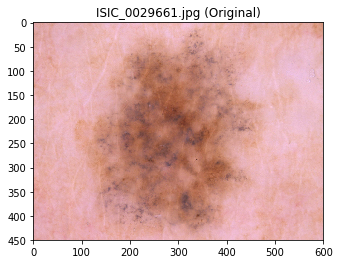

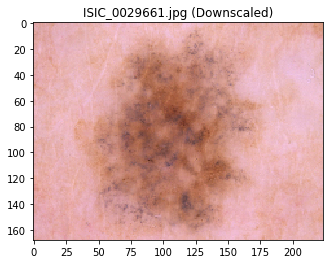

In [2]:
# Visualize 450*600 image
from PIL import Image

index = np.random.choice(range(500))

images = os.listdir('/home/ubuntu/Data/Skin/data/train/NV/')

img = Image.open('/home/ubuntu/Data/Skin/data/train/NV/' + images[index], 'r')

compressed_image = img.resize((224, 168))

fig = plt.figure()
plt.title('{} (Original)'.format(images[index]))
plt.imshow(img)
plt.show()

fig = plt.figure()
plt.title('{} (Downscaled)'.format(images[index]))
plt.imshow(compressed_image)
plt.show()

In [3]:
BATCH_SIZE = 12
SEED = 10

IM_HEIGHT = 450
IM_WIDTH = 600

np.random.seed(SEED)

global_mean = np.load('np_mean_rounded_nonweighted.npz')['image']
global_std = np.load('np_std_rounded_nonweighted.npz')['image']

# Resize by converting to PIL.
# img_global_mean = Image.fromarray(global_mean).convert('RGB').resize((IM_WIDTH, IM_HEIGHT))
# img_global_std = Image.fromarray(global_std).convert('RGB').resize((IM_WIDTH, IM_HEIGHT))

# # Convert back to ndarray                                                                   
# _global_mean = np.array(img_global_mean)
# _global_std = np.array(img_global_std)

# print(_global_mean.shape)
# print(_global_std.shape)

In [4]:
def preprocess_image(image):
    return (image - global_mean)/(global_std + K.epsilon())

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight

img_gen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_gen = img_gen.flow_from_directory('/home/ubuntu/Data/Skin/data/train/', 
                                        target_size=(IM_HEIGHT, IM_WIDTH), 
                                        class_mode='categorical', 
                                        shuffle=True, 
                                        batch_size=BATCH_SIZE)

val_gen = img_gen.flow_from_directory('/home/ubuntu/Data/Skin/data/val/', 
                                        target_size=(IM_HEIGHT, IM_WIDTH), 
                                        class_mode='categorical', 
                                        shuffle=True, 
                                        batch_size=BATCH_SIZE)

y_train = train_gen.classes
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print('---------------------------------------')
print('Class weights: ', class_weights)
print('---------------------------------------')
print('Class indices: ', train_gen.class_indices)

Found 9263 images belonging to 7 classes.
Found 2313 images belonging to 7 classes.
---------------------------------------
Class weights:  {0: 1.6857142857142857, 1: 2.5447802197802196, 2: 1.5037337662337662, 3: 3.595885093167702, 4: 1.4851691518358185, 5: 0.2466975604559497, 6: 2.9083202511773942}
---------------------------------------
Class indices:  {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras import Model
from keras.layers import (Dense, Activation, Dropout, 
                          BatchNormalization, Flatten, GlobalAveragePooling2D)

inc = InceptionV3(include_top=False, input_shape=(IM_HEIGHT, IM_WIDTH, 3), weights='imagenet')
x = inc.output
x = GlobalAveragePooling2D()(x)
x = Dense(40)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

out = Dense(7, activation='softmax')(x)

model = Model(inputs=inc.input, outputs=out)

for i, layer in enumerate(model.layers):
    if type(layer) is BatchNormalization:
        layer = BatchNormalization()(model.layers[i-1].output)

for layer in inc.layers:
    layer.trainable = False

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

_ = model.fit_generator(train_gen, 
                        steps_per_epoch=train_gen.samples//BATCH_SIZE + 1, 
                        validation_data=val_gen, 
                        validation_steps=val_gen.samples//BATCH_SIZE + 1, 
                        shuffle=True, 
                        epochs=1, 
                        class_weight=class_weights)

Epoch 1/1
772/772 [==============================] - 269s 349ms/step - loss: 1.3821 - val_loss: 1.7469


In [11]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return ( 2*(precision * recall) / (precision + recall + K.epsilon()) )

In [12]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return (true_positives / (predicted_positives + K.epsilon()))

In [13]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return (true_positives / (possible_positives + K.epsilon()))

In [15]:
from keras.optimizers import Adam

for layer in model.layers:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4, decay=0.005),
              metrics=['categorical_accuracy', precision, recall, f1])

print('Model compiled for fine tuning')

Model compiled for fine tuning


In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('inception--baseline--2--adam.h5', 
                             save_best_only=True, mode='max',
                             monitor='val_f1', verbose=1)

stopper = EarlyStopping(monitor='val_loss', mode='min', patience=4)

h = model.fit_generator(train_gen, 
                        steps_per_epoch=train_gen.samples//BATCH_SIZE + 1, 
                        validation_data=val_gen, 
                        validation_steps=val_gen.samples//BATCH_SIZE + 1, 
                        shuffle=True, 
                        epochs=40, 
                        class_weight=class_weights, 
                        callbacks=[checkpoint, stopper])

fig = plt.figure()
plt.plot(h.history['loss'], 'r-')
plt.plot(h.history['val_loss'], 'b-')
plt.show()

fig = plt.figure()
plt.plot(h.history['f1'], 'r-')
plt.plot(h.history['val_f1'], 'b-')
plt.show()

Epoch 1/40
772/772 [==============================] - 771s 998ms/step - loss: 0.9155 - categorical_accuracy: 0.6153 - precision: 0.7386 - recall: 0.4539 - f1: 0.5552 - val_loss: 0.9265 - val_categorical_accuracy: 0.6489 - val_precision: 0.7819 - val_recall: 0.5231 - val_f1: 0.6207

Epoch 00001: val_f1 improved from -inf to 0.62067, saving model to inception--baseline--2--adam.h5
Epoch 2/40
772/772 [==============================] - 741s 960ms/step - loss: 0.6031 - categorical_accuracy: 0.7204 - precision: 0.8171 - recall: 0.5744 - f1: 0.6684 - val_loss: 0.8592 - val_categorical_accuracy: 0.6857 - val_precision: 0.7853 - val_recall: 0.5629 - val_f1: 0.6507

Epoch 00002: val_f1 improved from 0.62067 to 0.65067, saving model to inception--baseline--2--adam.h5
Epoch 3/40
772/772 [==============================] - 741s 959ms/step - loss: 0.4976 - categorical_accuracy: 0.7614 - precision: 0.8503 - recall: 0.6311 - f1: 0.7193 - val_loss: 0.7142 - val_categorical_accuracy: 0.7717 - val_precisi

KeyboardInterrupt: 

In [ ]:
'''
#TODO:
1) Actvation maps
'''